In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, VGG16, MobileNetV3Small, EfficientNetB0, EfficientNetV2B0, ResNet50
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from skimage import exposure
import os
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob as gb
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Constants and Hyperparameters
resize = 224
learning_rate = 1e-4
seed = 107
INIT_LR = 1e-4
EPOCHS = 3     #set to 30 at orginal presentation
BS = 64

# Directory paths
base_dir = '/content/drive/MyDrive/Project/Data/skin_dataset'
TRAIN_DIR = os.path.join(base_dir, 'train')
TEST_DIR = os.path.join(base_dir, 'test')
VALID_DIR = os.path.join(base_dir, 'valid')

# Check if directories exist
assert os.path.exists(TRAIN_DIR), 'Could not find' + TRAIN_DIR
assert os.path.exists(TEST_DIR), 'Could not find' + TEST_DIR

100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


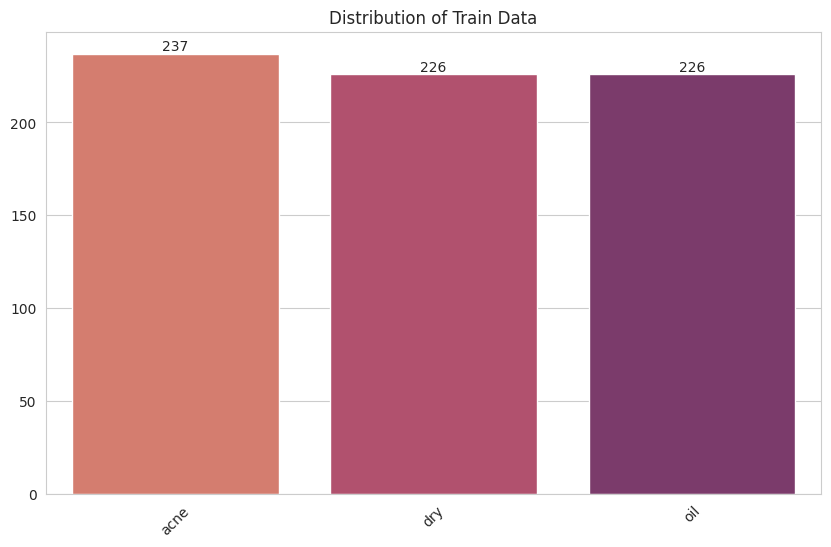

689


100%|██████████| 226/226 [00:05<00:00, 38.50it/s] 


In [4]:
# Data visualization
categories = []
class_count = []
train_exm = 0

for f in tqdm(os.listdir(TRAIN_DIR)):
    files = gb.glob(pathname=str(TRAIN_DIR + '/' + f + '/*'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

# sns.barplot(x=categories, y=class_count).set_title("Distribution of Train Data")
# plt.show()

# Using seaborn for barplot
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=categories, y=class_count, hue=categories, palette='flare', dodge=False)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribution of Train Data')
plt.xticks(rotation=45)

# Check if legend exists before trying to remove it
if ax.legend_ is not None:
    ax.legend_.remove()

plt.show()
print(train_exm)


# Data loading and preprocessing
data = []
labels = []

for c in categories:
    path = os.path.join(TRAIN_DIR, c)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(resize, resize))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(c)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [5]:
len(labels)

689

In [6]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{'acne': 237, 'dry': 226, 'oil': 226}

In [7]:
# Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
# Data Augmentation
AugmentedData = ImageDataGenerator(
    zoom_range=0.15, #Randomly zooms the images zoom in up to 15%
    rotation_range=360,  # Randomly rotates the images Set to 360 to cover all possible rotations
    width_shift_range=0.1, #Randomly shifts the images horizontally
    height_shift_range=0.1, #Randomly shifts the images vertically
    #shear transformation will be applied with a maximum shear angle of 0.15 degreesto 0.20. shear_range=(0.15, 0.2)
    shear_range=0.15, #A positive shear angle tilts the image to the right, while a negative shear angle tilts it to the left.
    #handle variations in facial structure
    brightness_range=[0.5, 1.5], #brightness of the images can be adjusted to be as dark as 50% of the original brightness or as bright as 150%
    # rescale=1./255,  #rescaling for data preprocessing pixel values in the range [0, 255], dividing by 255 ensures that the values are scaled to be between 0 and 1 NORMALIZATION
    horizontal_flip=True, #Randomly flips the images horizontally
    fill_mode="nearest" #Strategy for filling in newly created pixels
    #Options include "nearest" (fill with nearest pixel value) or others like "constant," "reflect," or "wrap."
)

# Custom function for contrast stretching
def contrast_stretching(image):
    p2, p98 = np.percentile(image, (2, 98)) #2nd and 98th percentiles of pixel intensities in the image.
    return exposure.rescale_intensity(image, in_range=(p2, p98)) #skimage library & exposure

# Applying contrast stretching during data augmentation
AugmentedData.preprocessing_function = contrast_stretching

# contrast_stretching=(0.5, 2.0), #contrast of the images can be adjusted to be as low as 50% of the original contrast or as high as 100%

In [9]:
# Model names dictionary
model_dict = {
    'VGG16': VGG16,
    'MobileNetV2' : MobileNetV2,
    'MobileNetV3Small': MobileNetV3Small,
    'ResNet50': ResNet50,
    'EfficientNetB0': EfficientNetB0,
    'EfficientNetV2B0': EfficientNetV2B0
}

In [10]:
# Choose the desired model
model_name = 'MobileNetV3Small'
base_model = model_dict[model_name](weights='imagenet', include_top=False, input_shape=(resize, resize, 3))
base_model.summary()

# (A simple CNN as the Head model) a custom head for classification
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256, activation="relu")(head_model)
head_model = Dropout(0.25)(head_model)
head_model = Dense(3, activation="softmax")(head_model)

# Combine the base model and head model
model = Model(inputs=base_model.input, outputs=head_model)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 113, 113, 16)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 56, 56, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 1, 1, 16)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)  

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [11]:
# Split data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)
print(f"Shape of x_train: {trainX.shape}")
print(f"Shape of y_train: {trainY.shape}")
print()
print(f"Shape of x_test: {testX.shape}")
print(f"Shape of y_test: {testY.shape}")

Shape of x_train: (551, 224, 224, 3)
Shape of y_train: (551, 3)

Shape of x_test: (138, 224, 224, 3)
Shape of y_test: (138, 3)


In [12]:
# Determine the loss function based on the number of classes
if len(categories) > 2:
    loss_function = "categorical_crossentropy"
else:
    loss_function = "binary_crossentropy"

# Compile the model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss=loss_function, optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [13]:
# Train the model
H = model.fit(
    AugmentedData.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.3469 - loss: 1.1291 - val_accuracy: 0.3406 - val_loss: 1.2653
Epoch 2/3
1/8 ━━━━━━━━━━━━━━━━━━━━ 5s 716ms/step - accuracy: 0.3125 - loss: 1.1024

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.3125 - loss: 1.1024 - val_accuracy: 0.3188 - val_loss: 1.2688
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3037 - loss: 1.1284 - val_accuracy: 0.3188 - val_loss: 1.2715


In [14]:
# Save training history to JSON
hist_df = pd.DataFrame(H.history)
with open(f'{model_name.lower()}_history.json', mode='w') as f:
    hist_df.to_json(f)

[INFO] evaluating network...
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
              precision    recall  f1-score   support

           0       0.45      0.29      0.35        48
           1       0.00      0.00      0.00        45
           2       0.28      0.67      0.40        45

    accuracy                           0.32       138
   macro avg       0.24      0.32      0.25       138
weighted avg       0.25      0.32      0.25       138



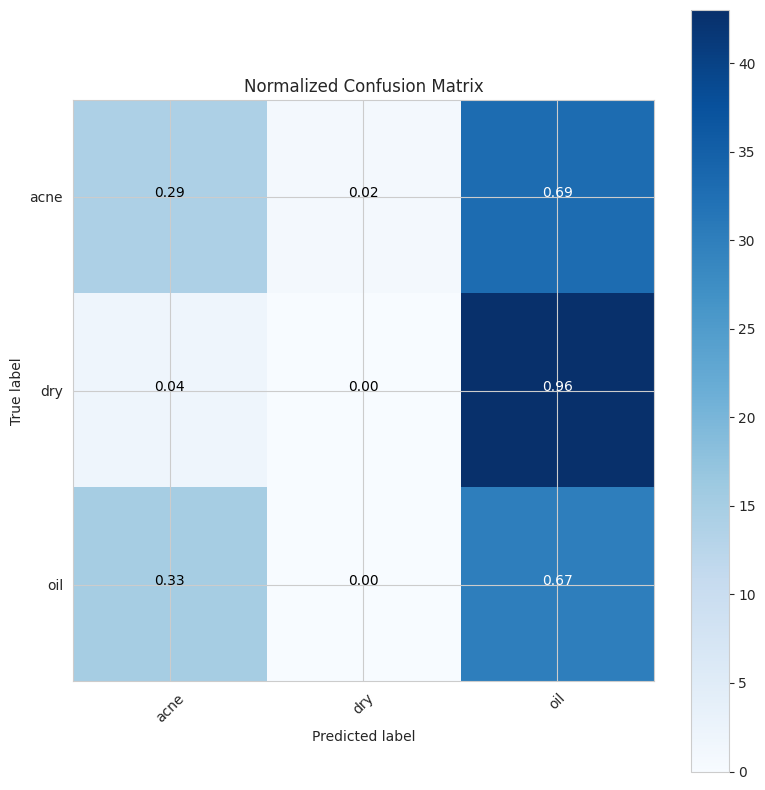

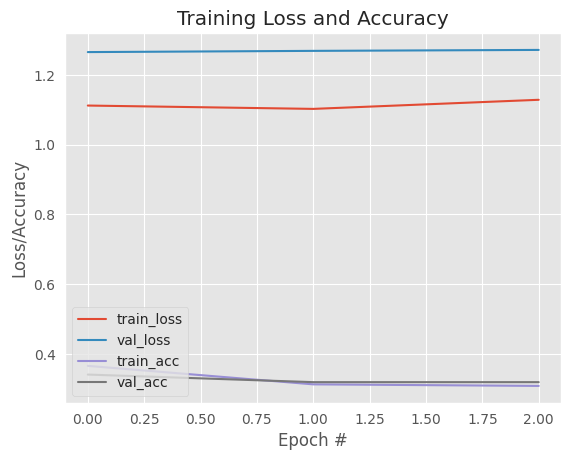

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Evaluate the model
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs))

# Generate confusion matrix
confusion_mtx = confusion_matrix(testY.argmax(axis=1), predIdxs)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(confusion_mtx, classes=categories, normalize=True, title='Normalized Confusion Matrix')
plt.show()

# Plot training history
N = EPOCHS

plt.style.use("ggplot")
sns.set_palette("husl")

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [16]:
# Save the model in Keras format
model.save(f"{model_name.lower()}_skin_classification_model.keras")